# Predicción de la demanda de taxis utilizando modelos de aprendizaje supervisado y análisis de series temporales

## Introducción

El presente proyecto tiene como objetivo desarrollar un modelo predictivo que permita a Sweet Lift Taxi anticipar la demanda de taxis en diferentes horas del día. Para lograr esto, se emplearán técnicas de aprendizaje automático y análisis de series temporales, aprovechando datos históricos de demanda,para atraer a más conductores durante las horas pico.

### Descripción del conjunto de datos

El conjunto de datos utilizado en este proyecto está almacenado en el archivo `/datasets/taxi.csv` y contiene el número de pedidos en la columna `num_orders`.

## Descarga de los datos y remuestreo

In [1]:
# Cargar módulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
plt.style.use('ggplot')

In [2]:
# Cargar conjunto de datos
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Descripción de los datos

In [3]:
# Vista parcial
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Medidas descriptivas
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


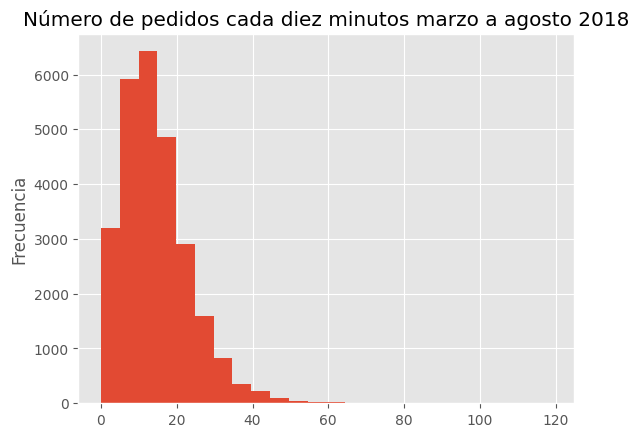

In [6]:
# Histograma
df.plot(kind='hist', 
        bins=24,
        title='Número de pedidos cada diez minutos marzo a agosto 2018',
        legend=False
       )
plt.ylabel('Frecuencia')
plt.show()

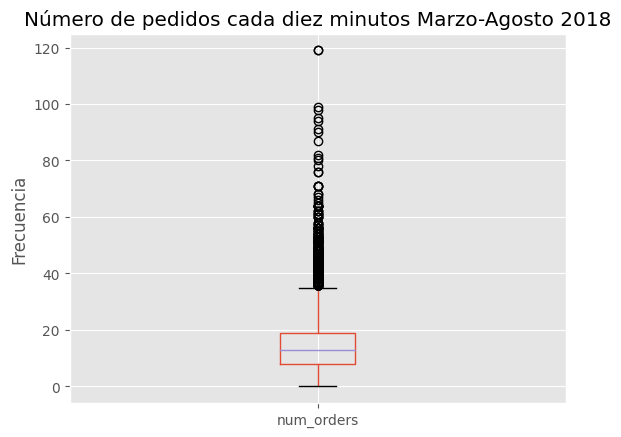

In [7]:
# Diagrama de caja y brazos
df.plot(kind='box',
        title='Número de pedidos cada diez minutos Marzo-Agosto 2018')
plt.ylabel('Frecuencia')
plt.show()

Se destaca que los datos están en orden cronológico, abarcando desde el 1 de marzo de 2018 hasta el 31 de agosto de 2018. Cada observación representa el número de pedidos cada diez minutos. Se observa que el promedio de pedidos es 14, el cual es mayor a la mediana, indicando una asimetría positiva con un sesgo hacia la derecha. El valor mínimo de pedidos es cero, el máximo es 119 en un período de diez minutos y se registran valores extremadamente altos.

### Remuestreo

In [8]:
# Ordenar el DataFrame por fecha y hora
df.sort_index(inplace=True)

In [9]:
# Remuestreo: sumar el número de pedidos para cada hora
df = df.resample('1H').sum()

In [10]:
# Crear una copia del DataFrame remuestreado
df_copy = df

In [11]:
# Calcular la media móvil y la desviación estándar móvil de 24 horas del número de pedidos
df_copy['rolling_mean'] = df['num_orders'].rolling(24).mean()
df_copy['rolling_std'] = df['num_orders'].rolling(24).std()

Se remuestrea los datos de pedidos de taxis a intervalos de una hora, y luego calcula la media móvil y la desviación estándar móvil de 24 horas para analizar las tendencias y variaciones en la demanda horaria de taxis en la siguiente sección.

## Análisis

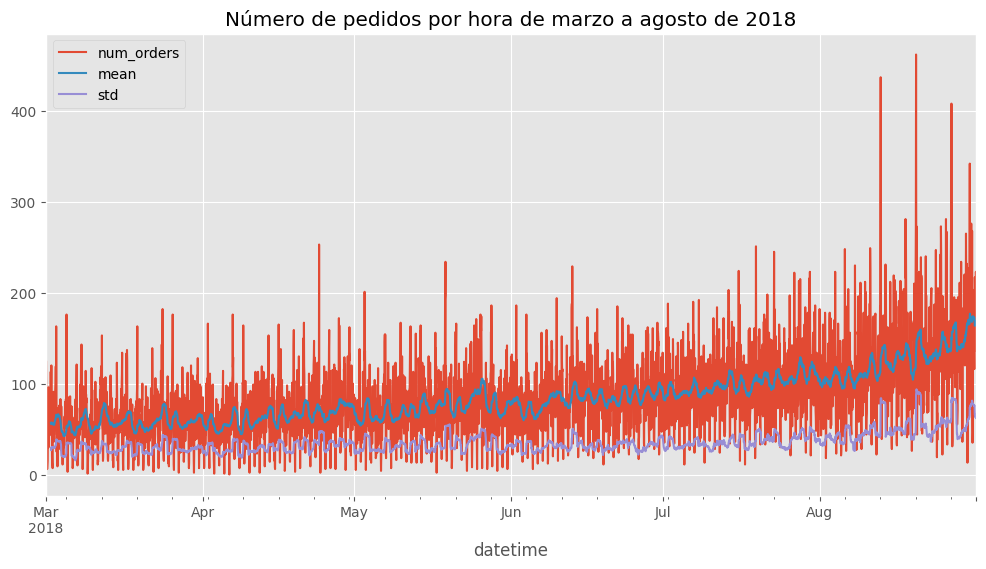

In [12]:
# Grafica del número de pedidos por hora, la media móvil y la desviación estándar móvil de marzo a agosto de 2018
df_copy.plot(figsize=(12,6),
       title='Número de pedidos por hora de marzo a agosto de 2018')
plt.legend(['num_orders', 'mean', 'std'])
plt.show()

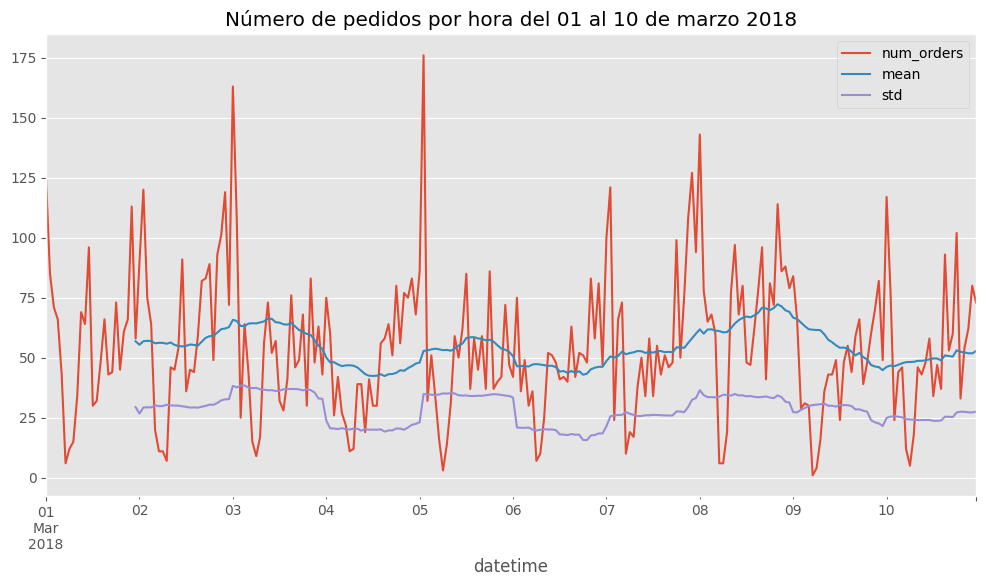

In [13]:
# Grafica del número de pedidos por hora, la media móvil y la desviación estándar móvil del 1 al 10 de marzo de 2018
df_copy['2018-03-01':'2018-03-10'].plot(figsize=(12,6),
                                  title='Número de pedidos por hora del 01 al 10 de marzo 2018')
plt.legend(['num_orders', 'mean', 'std'])
plt.show()

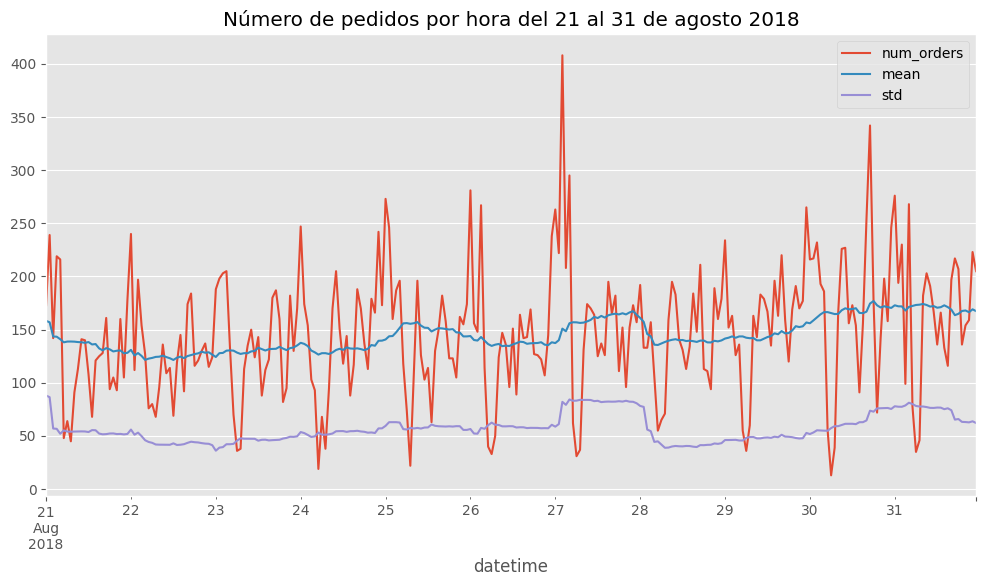

In [14]:
# Graficar el número de pedidos por hora, la media móvil y la desviación estándar móvil del 21 al 31 de agosto de 2018
df_copy['2018-08-21':'2018-08-31'].plot(figsize=(12,6),
                                   title='Número de pedidos por hora del 21 al 31 de agosto 2018')
plt.legend(['num_orders', 'mean', 'std'])
plt.show()

Estas gráficas ayudan a entender la distribución y variabilidad de los datos de pedidos de taxis y las medidas móviles calculadas, identificando una tendencia creciente a lo largo del día donde la variabilidad de los datos es estable durante este periodo.

### Tendencias y estacionalidad


En esta sección se descompone la serie temporal de pedidos de taxis en sus componentes de tendencia, estacionalidad y residuos, y luego se visualizan.

In [15]:
# Descomposición de la serie temporal en tendencia, estacionalidad y residuos
decomposed = seasonal_decompose(df['num_orders'])

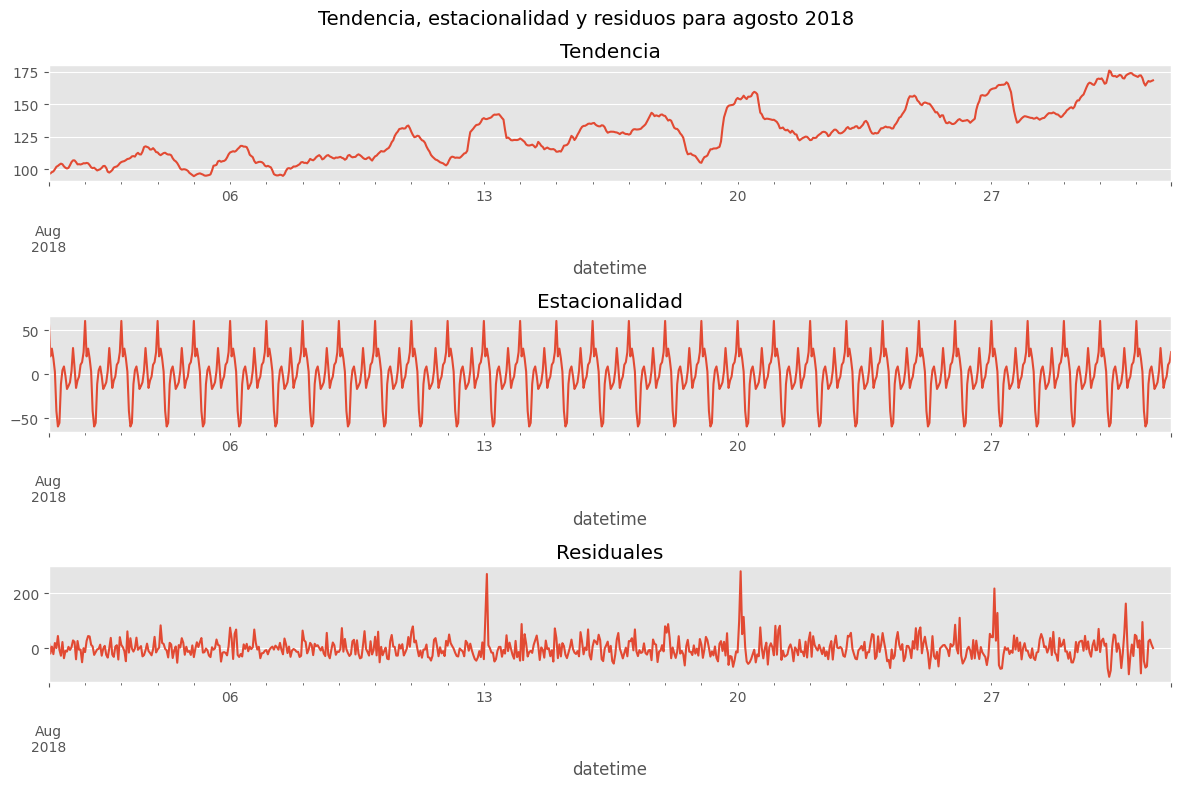

In [16]:
# Graficar la tendencia, estacionalidad y residuales para agosto 2018

plt.figure(figsize=(12, 8))
plt.suptitle('Tendencia, estacionalidad y residuos para agosto 2018', fontsize=14)

plt.subplot(311)
decomposed.trend['2018-08'].plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal['2018-08'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid['2018-08'].plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()
plt.show()

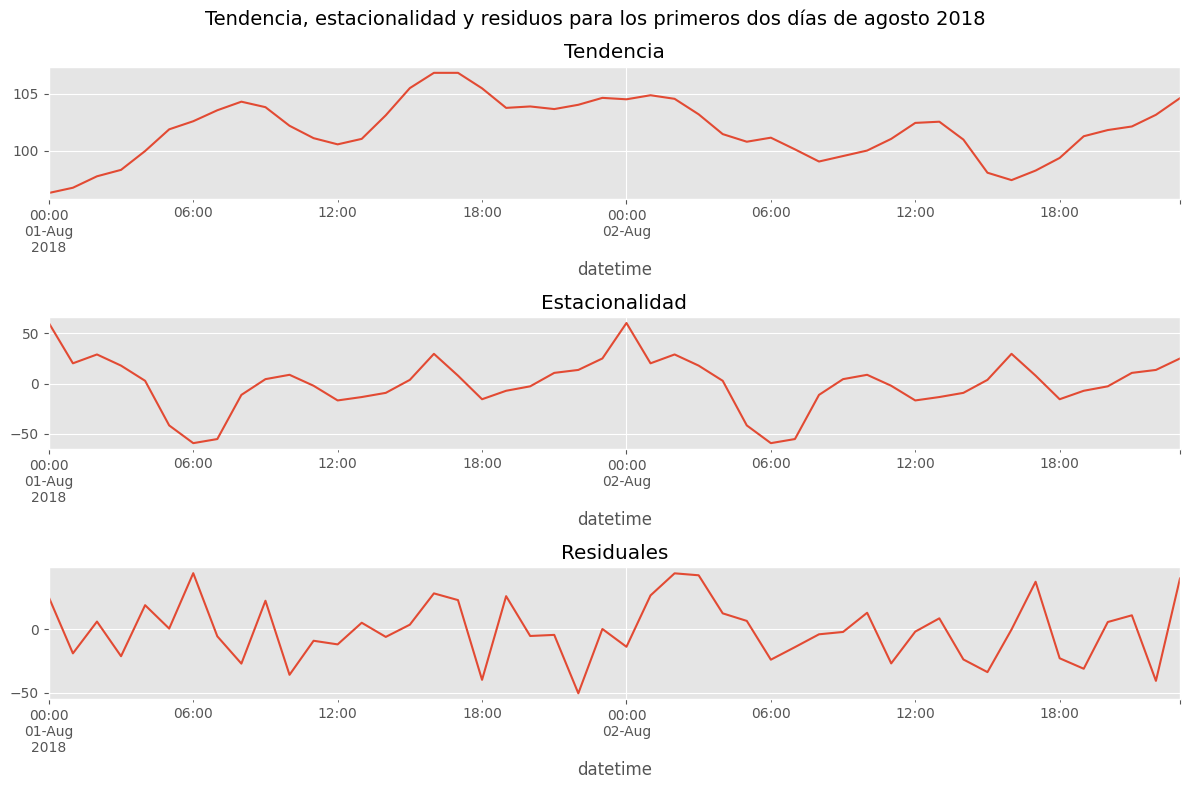

In [17]:
# Graficar la tendencia, estacionalidad y residuales para los primeros dos días de agosto 2018
plt.figure(figsize=(12, 8))
plt.suptitle('Tendencia, estacionalidad y residuos para los primeros dos días de agosto 2018', fontsize=14)

plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()
plt.show()

### Creación de características

In [18]:
# Creación de la función make_features()
def make_features(data, max_lag, rolling_mean_size):
    '''''''''
    La función make_features agrega nuevas columnas al conjunto de datos basándose 
    en la fecha y hora de cada registro.
    '''''''''
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

# Aplicamos la función make_features con 12 características de desfase y 24 como tamaño de ventana
make_features(df, 12, 24)

In [19]:
# Eliminar valores ausentes
df_final = df.dropna()

In [20]:
# Vista parcial
df_final.head()

,num_orders,rolling_mean,rolling_std,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.833333,26.730404,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0
2018-03-02 01:00:00,120,55.416667,29.250511,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0
2018-03-02 02:00:00,75,56.875000,29.345734,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0
2018-03-02 03:00:00,64,57.041667,29.322019,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0
2018-03-02 04:00:00,20,56.958333,30.161882,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0


Se crearon nuevas características derivadas de la serie temporal original para mejorar la calidad de los modelos preductivos que se implementaran en la siguiente sección.

## Prueba

### Prueba de cordura

In [21]:
# Dividir datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(df['num_orders'], shuffle=False, test_size=0.1)

In [22]:
# Predicciones basadas en el valor anterior y los valores reales de prueba.
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
RECM_max = mean_squared_error(test, pred_previous, squared=False)

In [23]:
# Imprimir los resultados
print('Prueba de cordura')
print(f'RECM: {RECM_max:.4f}')

Prueba de cordura
RECM: 58.8565


### Regresión lineal

In [24]:
# Dividir datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(df_final, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
# Entrenar el modelo
model = LinearRegression()
model.fit(features_train, target_train)

# Realizar predicciones 
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

In [26]:
# Evaluar el modelo
RECM_lr = mean_squared_error(target_test, pred_test, squared=False)

In [27]:
# Imprimir los resultados
print('Regresión lineal')
print(f'RECM: {RECM_lr:.4f}')

Regresión lineal
RECM: 50.7108


### Bosque aleatorio


In [28]:
# Definir la búsqueda de hiperparámetros para el bosque aleatorio
params_rf = {
    'n_estimators' : [10, 20],
    'max_depth': [5, 10, 15] , 
    'min_samples_split': [5, 10, 15],
}

# Realizar la búsqueda de hiperparámetros
gridSearch_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_rf, scoring='neg_root_mean_squared_error')

In [29]:
# Entrenar el modelo
gridSearch_rf.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 20]},
             scoring='neg_root_mean_squared_error')

In [30]:
# Obtener los mejores hiperparámetros y el mejor puntaje (RMSE)
best_params = gridSearch_rf.best_params_
best_rmse = -gridSearch_rf.best_score_

# Mostrar resultados
print(f'Mejores hiperparámetros: {best_params} | Mejor RMSE: {best_rmse:.4f}')

Mejores hiperparámetros: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 20} | Mejor RMSE: 28.3524


In [31]:
# Entrenar el modelo de bosques aleatorios
rf_model = RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=20, min_samples_split=5)
rf_model.fit(features_train, target_train)


# Realizar predicciones

target_pred_rf = rf_model.predict(features_test)


# Calcular el RECM
RECM_rf = mean_squared_error(target_test, target_pred_rf, squared=False)

# Imprimir los resultados
print('Bosques aleatorios')
print(f'RECM: {RECM_rf:.4f}')

Bosques aleatorios
RECM: 51.0491


### CatBoost

In [32]:
# Definir la búsqueda de hiperparámetros para CatBoost
params_catboost = {
    'learning_rate': [0.1, 0.2, 0.3],
    'depth': [6, 8, 10]
}

# Realizamos la búsqueda de hiperparámetros
catboost_model = CatBoostRegressor(iterations=100, verbose=False, loss_function='RMSE')

gridSearch_catboost = GridSearchCV(estimator=catboost_model, param_grid=params_catboost, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

# Entrenamos el modelo 

gridSearch_catboost.fit(features_train, target_train)


# Mostramos los mejores parámetros encontrados
best_params = gridSearch_catboost.best_params_
best_rmse = -gridSearch_catboost.best_score_
print(f'Mejores hiperparámetros: {best_params} | Mejor RMSE: {best_rmse:.4f}')

Mejores hiperparámetros: {'depth': 8, 'learning_rate': 0.2} | Mejor RMSE: 27.2879


In [33]:
# Entrenamos el modelo catboost

cb_model = CatBoostRegressor(random_seed=12345, iterations=100, depth=8,learning_rate=0.2)
cb_model.fit(features_train, target_train, verbose=False)

# Predicciones
target_pred_cb = cb_model.predict(features_test)


# Calcular el RECM
RECM_cb = mean_squared_error(target_test, target_pred_cb, squared=False)

# Imprimir los resultados
print('CatBoost')
print(f'RECM: {RECM_cb:.4f}')

CatBoost
RECM: 50.0933


### LightGBM

In [34]:
# Definir la búsqueda de hiperparámetros para LightGBM
params_lightgbm = {
    'n_estimators': [300,400],
    'learning_rate': [0.2, 0.25], #'learning_rate': [0.2, 0.5],
    'num_leaves': [30, 40] # 'num_leaves': [10, 20, 30]
}

# Realizamos la búsqueda de hiperparámetros
lightgbm_est = LGBMRegressor()
gridSearch_lightgbm = GridSearchCV(estimator=lightgbm_est, param_grid=params_lightgbm, scoring='neg_root_mean_squared_error')

In [35]:
# Entrenamos el modelo 

gridSearch_lightgbm.fit(features_train, target_train)


# Mostramos los mejores parámetros encontrados
best_params = gridSearch_lightgbm.best_params_
best_rmse = -gridSearch_lightgbm.best_score_
print(f'Mejores hiperparámetros: {best_params} | Mejor RMSE: {best_rmse:.4f}')

Mejores hiperparámetros: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 40} | Mejor RMSE: 27.5858


In [36]:
# Entrenamos el modelo

lightgbm_model = LGBMRegressor(random_state=12345, n_estimators=300, learning_rate=0.2, num_leaves=40)
lightgbm_model.fit(features_train, target_train)

# Realizamos predicciones

y_pred_lb = lightgbm_model.predict(features_test)


# Calcular el RECM
RECM_lb = mean_squared_error(target_test, y_pred_lb, squared=False)

# Imprimir los resultados
print('CatBoost')
print(f'RECM: {RECM_lb:.4f}')

CatBoost
RECM: 47.9092


### XGBoost

In [37]:
# Definir la búsqueda de hiperparámetros para XGBoost
params_xgboost = {
    'max_depth': [6, 8],
    'n_estimators': [100, 150],
    'learning_rate': [0.2, 0.3]
}

# Realizamos la búsqueda de hiperparámetros
xboost_est = XGBRegressor()
gridSearch_xboost = GridSearchCV(estimator=xboost_est, param_grid=params_xgboost, scoring='neg_root_mean_squared_error')

In [38]:
# Entrenamos el modelo 
gridSearch_xboost.fit(features_train, target_train)

# Mostramos los mejores parámetros encontrados
best_params = gridSearch_xboost.best_params_
best_rmse = -gridSearch_xboost.best_score_
print(f'Mejores hiperparámetros: {best_params} | Mejor RMSE: {best_rmse:.4f}')

Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100} | Mejor RMSE: 27.4145


In [39]:
# Entrenamos el modelo
xb_model = XGBRegressor(random_state=12345, learning_rate=0.2,  max_depth=6, n_estimators= 100)
xb_model.fit(features_train, target_train)

# Realizamos predicciones

taget_pred_xg = xb_model.predict(features_test)


# Calcular el RECM
RECM_xg = mean_squared_error(target_test, taget_pred_xg, squared=False)

# Imprimir los resultados
print('CatBoost')
print(f'RECM: {RECM_xg:.4f}')

CatBoost
RECM: 51.6546


### Comparación de los modelos

In [40]:
# Comparación de modelos
model_versus = pd.DataFrame({
    'Modelo': ['Prueba de cordura', 'Regresión Lineal', 'Bosque Aleatorio', 'CatBoost', 'LightGBM', 'XGBoost'],
    'RECM': [RECM_max, RECM_lr,  RECM_rf, RECM_cb, RECM_lb, RECM_xg]
     
})

model_versus

,Modelo,RECM
0,Prueba de cordura,58.856486
1,Regresión Lineal,50.710789
2,Bosque Aleatorio,51.049066
3,CatBoost,50.093271
4,LightGBM,47.909202
5,XGBoost,51.654554


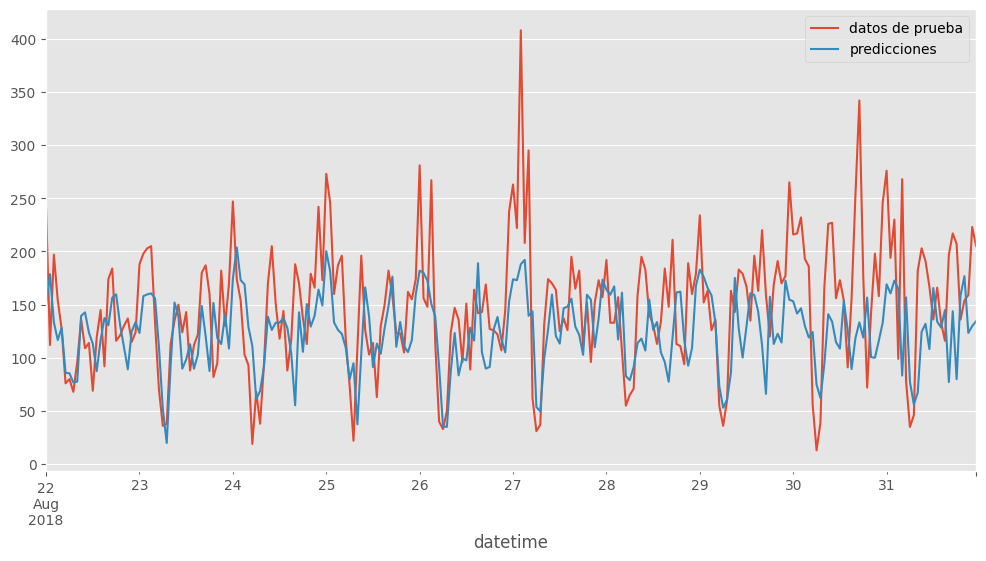

In [41]:
# Graficar predicciones del mejor modelo 
pd.concat([target_test,pd.DataFrame(taget_pred_xg, index= target_test.index)], axis=1).tail(240).plot(figsize=(12,6))
plt.legend(['datos de prueba', 'predicciones'])
plt.show()

Se realizan diferentes pruebas y comparaciones de modelos de predicción sobre los datos de series temporales de donde se obtuvo que el mejor modelo es LightGBM con una métrica RECM inferior a 48. Los mejores hiperparámetros para el modelo LightGBM encontrados son: `learning_rate`: 0.2, `n_estimators`: 300 y `num_leaves`: 40.

## Conclusiones


- El conjunto de datos abarcó desde el 1 de marzo de 2018 hasta el 31 de agosto de 2018, con registros de pedidos de taxis cada diez minutos.

- Los datos se remuestrearon a intervalos de una hora para facilitar el análisis y la predicción.

- Se generaron nuevas características a partir de la serie temporal original, incluyendo desfases y medias móviles, con el fin de mejorar la calidad de los modelos predictivos.

- Se evaluaron varios modelos entre ellos Regresión Lineal, Bosque Aleatorio, CatBoost, LightGBM y XGBoost.

- El modelo LightGBM reportó el mejor rendimiento con una metrica de RECM de 47.9092, superando a los otros modelos para predecir la demanda de taxis.